<a href="https://colab.research.google.com/github/DarekGit/FACES_DNN/blob/master/notebooks/06_01_FDDB_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

[Spis treści](https://github.com/DarekGit/FACES_DNN/blob/master/notebooks/Praca_Dyplomowa.ipynb) | [1. Wstęp](01_00_Wstep.ipynb) | [2. Metryki oceny detekcji](02_00_Miary.ipynb) | [3 .Bazy danych](03_00_Datasety.ipynb) | [4. Przegląd metod detekcji](04_00_Modele.ipynb) | [5. Detekcja twarzy z wykorzystaniem wybranych architektur GSN](05_00_Modyfikacje.ipynb) | [6. Porównanie modeli](06_00_Porownanie.ipynb) | [7. Eksport modelu](07_00_Eksport_modelu.ipynb) | [8. Podsumowanie i wnioski](08_00_Podsumowanie.ipynb) | [Bibliografia](Bibliografia.ipynb)


---

# 6.1. Ewaluacja modeli na zbiorze walidacyjnym FDDB

Instalacja Detectron2, pobranie datasetu i narzędzi

In [ ]:
# install detectron2:

!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -q -e detectron2_repo

In [ ]:
!wget http://tamaraberg.com/faceDataset/originalPics.tar.gz
!wget vis-www.cs.umass.edu/fddb/FDDB-folds.tgz
!mkdir FDDB
!tar -C FDDB -zxf originalPics.tar.gz > /dev/null
!tar -C FDDB -zxf FDDB-folds.tgz > /dev/null

--2020-08-20 20:02:48--  http://tamaraberg.com/faceDataset/originalPics.tar.gz
Resolving tamaraberg.com (tamaraberg.com)... 54.221.205.183
Connecting to tamaraberg.com (tamaraberg.com)|54.221.205.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579061091 (552M) [application/x-gzip]
Saving to: ‘originalPics.tar.gz’

originalPics.tar.gz 100%[===================>] 552.24M  9.29MB/s    in 84s     

2020-08-20 20:04:12 (6.55 MB/s) - ‘originalPics.tar.gz’ saved [579061091/579061091]

--2020-08-20 20:04:14--  http://vis-www.cs.umass.edu/fddb/FDDB-folds.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160724 (157K) [application/x-gzip]
Saving to: ‘FDDB-folds.tgz’

FDDB-folds.tgz      100%[===================>] 156.96K   164KB/s    in 1.0s    

2020-08-20 20:04:16 (164 KB/s) - ‘FDDB-folds.tgz’ sav

In [ ]:
# mobilenet
!gdown https://drive.google.com/uc?id=1U0SVkSaSio4TBiXvF1QfTZI65WYpXpZ9
!unzip -qo mobilenet.zip
!rm -f mobilenet.zip

# Tools
!gdown https://drive.google.com/uc?id=1_9ydMZlTNFXBOMl16xsU8FSBmK2PW4lN -O FDDB/tools.py
!wget -q -O FDDB/mAP.py https://drive.google.com/uc?id=1PtEsobTFah3eiCDbSsYblOGbe2fmkjGR

Downloading...
From: https://drive.google.com/uc?id=1U0SVkSaSio4TBiXvF1QfTZI65WYpXpZ9
To: /content/mobilenet.zip
100% 11.8k/11.8k [00:00<00:00, 19.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_9ydMZlTNFXBOMl16xsU8FSBmK2PW4lN
To: /content/FDDB/tools.py
100% 4.47k/4.47k [00:00<00:00, 3.97MB/s]


<font color=yellow> Restart runtime to continue... <b>Crtl+M.</b> </font>

In [ ]:
!nvidia-smi
from psutil import virtual_memory
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(virtual_memory().total / 1e9))

Thu Aug 20 20:43:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install facenet-pytorch
from facenet_pytorch import MTCNN

In [ ]:
import time
from tqdm.notebook import tqdm
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()


import gdown
from google.colab import drive
import os
import cv2
import random
import itertools
import shutil
import glob
import json
import numpy as np
import pandas as pd
from PIL import ImageDraw, Image
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import collections as mc

from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
import detectron2.utils.comm as comm
from detectron2.engine import DefaultPredictor, DefaultTrainer, HookBase
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.structures import BoxMode
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

from mobilenet.utils import  add_mobilenet_config, build_mobilenetv2_fpn_backbone
from FDDB.mAP import mAP, plot_mAP
from FDDB.tools import annotations,output_Files

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


Zapis danych na Google drive



In [ ]:
OUTPUT_DIR_NAME = "FDDB_OUTPUT_DIR"
drive.mount('/content/drive')
OUTPUT_DIR_PATH = os.path.join("./drive/My Drive", OUTPUT_DIR_NAME)

if not os.path.exists(OUTPUT_DIR_PATH):
  os.makedirs(OUTPUT_DIR_PATH)
  print("\ncfg.OUTPUT_DIR =",OUTPUT_DIR_PATH) 
else: 
  print("\ncfg.OUTPUT_DIR =",OUTPUT_DIR_PATH)

In [ ]:
IMAGES_PATH='FDDB/'

## Funkcja konwertująca anotacje eliptycze  FDDB do prostokątnych

In [ ]:
def fddb_rectangular_annotation(IMAGES_PATH=IMAGES_PATH):
  '''Funkcja wraca listę boxy obliczone na podstawie *ellipseList.txt
      i względną ścieżkę do pliku
      
      [{'boxes': array([[184.1439,  38.1979, 355.2429, 285.3645]]),
        'path': '2002/08/11/big/img_591'}]
  '''
  fddb_annotations =  []
  ellipseList = glob.glob(IMAGES_PATH+"FDDB-folds/*ellipseList.txt")
  ellipseList.sort()

  for item in ellipseList:
    with open(item, "r") as file_:
      rows = file_.readlines()
    
    idx = 0
    while (idx < len(rows)):
      tmp = []
      image_name = rows[idx].replace("\n", "")
      number_of_faces = int(rows[idx+1])
      boxes = []

      for i in range(1, number_of_faces+1):
        box = rows[idx+1+i]
        box = [float(item) for item in box.split(' ')[0:5]]
        xmin = float(box[3]- box[1])
        ymin = float(box[4]- box[0])
        xmax = float(xmin + box[1]*2)
        ymax = float(ymin + box[0]*2)
        boxes.append([xmin, ymin, xmax, ymax])
      
      boxes=np.array(boxes)
      fddb_annotations.append({'path':image_name,'boxes':boxes})
      idx += (number_of_faces+2)

  return fddb_annotations

In [ ]:
fddb_annotations = fddb_rectangular_annotation(IMAGES_PATH)
fddb_annotations[0]

{'boxes': array([[184.1439,  38.1979, 355.2429, 285.3645]]),
 'path': '2002/08/11/big/img_591'}

## Funkcja konwertująca anotacje do format wymaganego przez Detectron2

In [ ]:
def get_fddb_dict(annotations):
  '''Funkcja modyfikuje annotacje z fddb_rectangular_annotation()
  na słownik wymagany przez detectron2.data.DatasetCatalog

  {'annotations': [{'bbox': [59, 71, 269, 353],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0,
   'iscrowd': 0,
   'segmentation': [[59, 71, 269, 71, 269, 353, 59, 353]]}],
   'file_name': 'FDDB/2002/07/29/big/img_136.jpg',
   'height': 450,
  'image_id': 18,
  'width': 319}
  '''
  dataset_dicts = []
  for idx, item in enumerate(annotations):
    record = {}
    file_path = IMAGES_PATH+item["path"]+".jpg"

    record["file_name"] = file_path 
    record["image_id"] = idx
    record["height"], record["width"] = cv2.imread(file_path).shape[:2]

    objs = []
    for box in item["boxes"]:
      box = [int(i) for i in box] # int vs float..
      xmin, ymin, xmax, ymax = box
      poly = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]
      poly = list(itertools.chain.from_iterable(poly))

      obj = {
        "bbox": [xmin, ymin, xmax, ymax],
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": [poly],
        "category_id": 0,
        "iscrowd": 0
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)

  return dataset_dicts

Rejestracja datasetu dla Detectron2

In [ ]:
classes = ['face']
for d in ["val"]:
  DatasetCatalog.register("faces_" + d, lambda d=d: get_fddb_dict(fddb_annotations if d == "val" else "null"))
  MetadataCatalog.get("faces_" + d).set(thing_classes = classes)

faces_metadata = MetadataCatalog.get("faces_val")

In [ ]:
faces_metadata

Metadata(name='faces_val', thing_classes=['face'])

Wizualizacja annotacji na plikach z walidacyjnego

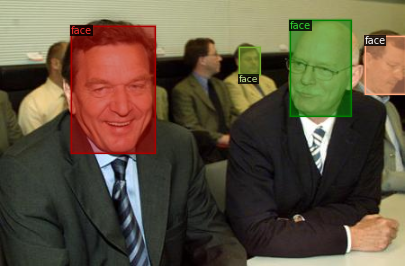

In [ ]:
dataset_dicts = get_fddb_dict(fddb_annotations)
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=faces_metadata, scale=0.9)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Modele do testu 

MobileNetV2

In [ ]:
models_mnv2 = {
    # '800k' - parametry domyślne - jako punkt odniesienia
    '800k': {
        'config': 'FrozenBN',
        'pth': 'https://drive.google.com/uc?id=1-tqNKwZIFmkAbfJ1L2sibIO4PT_MwnVA',
        'weights_name': 'model_0799999.pth'},

    # 'BN_800k' - dodano BN - pokazanie wpływu BN przy małym batchu=2
    'BN_800k': {
        'config': 'BN',
        'pth': 'https://drive.google.com/uc?id=1-kRDjqkMk9qXbNfzVx09VE35YzgkP1AO',
        'weights_name': 'model_0799999.pth'},

    #'BN_Mish_V2_250+F_2_50k' - najlepszy wynik uczenie z Mish BN 250k + 50k z FrozenBN
    'BN_Mish_V2_250+F_2_50k': {
        'config': 'BN_Mish_V2F',
        'pth': 'https://drive.google.com/uc?id=1-I6YSAs9NrORI4cFISfK_-4Yhm1twfDi',
        'weights_name': 'model_0049999.pth'},
    
    # 'BN_Mish_V3_80+30k' - najszybsze uczenie 110k iteracji
    'BN_Mish_V3_80+_30k': {
        'config': 'BN_Mish_V3',
        'pth': 'https://drive.google.com/uc?id=1--bP5VPyqIrfrBxVZ5eLSsupIvBlQ8ef',
        'weights_name': 'model_0029999.pth'},
    }

Faster R-CNN

In [ ]:
faster_rcnn_model = {
    'faster_rcnn_R_50_FPN_3x' : {
        'config': 'https://drive.google.com/uc?id=173XKeFyCXK909QA652WpEhQ3imlyDFKX',
        'config_file' : "faster_rcnn_R_50_FPN_3x.yaml",
        'pth': 'https://drive.google.com/uc?id=1-XGz6HOqJQWmDCJiJDbBl-FnK7ZxZu5z',
        'weights_name': 'model_0269999.pth' 
    },
    'scratch_faster_rcnn_R_50_FPN_gn' : {
        'config': 'https://drive.google.com/uc?id=1-IX6Dshhs-rin7m1lGtTl1xNaUQXK3kN',
        'config_file' : "scratch_faster_rcnn_R_50_FPN_gn.yaml",
        'pth': 'https://drive.google.com/uc?id=1-dqOloknew4wN0cD5xcFhbRlrA8rSHGt',
        'weights_name': 'model_0539999.pth' 
    }
}

MTCNN

In [ ]:
mtcnn = MTCNN(image_size=224, margin=0, keep_all=True, device=device)

## Zestawy konfiguracji podstawowych dla modeli opartych na MobileNetV2


In [ ]:
cfg_set = {
    'FrozenBN':'https://drive.google.com/uc?id=1rZFzJaR_g7uYuTguTdbUuCQYD4eXLeqw',
    'BN': 'https://drive.google.com/uc?id=1-doXtwe5iZHoqPzKGc2ZZbxj6Ebhxsn4',
    'BN_V2':'https://drive.google.com/uc?id=1wywB8UAaOO5KZx3IS35kV-rLsvJMIse6',
    'BN_Mish':'https://drive.google.com/uc?id=1-axV3KKg8-YiZZ7uDBh_2v181JoC9Nj3',
    'BN_Mish_V2':'https://drive.google.com/uc?id=1WoESx5RYvpapNicpSrmMoNJeE2GVm3zK',
    'BN_Mish_V3':'https://drive.google.com/uc?id=1-Kgd_2AS4EsD_ZPqP7SxkscyDjP-Qhnr',
    'BN_Mish_V2F':'https://drive.google.com/uc?id=1pCwyYCjIoduro2vIKMZi5HhlpaypH0_x',
    }

## DefaultPredictor dla modeli opartych na MobileNetV2

In [ ]:
def cfg_write(cfg,cfg_all):
  for key in cfg_all.keys():
    if isinstance(cfg_all[key],dict): 
      cfg_write(cfg[key],cfg_all[key])
    else: cfg[key]=cfg_all[key]
  return cfg

def set_predictor(model_name=None, models_dict=models_mnv2, cfg_dict=cfg_set ,device='cuda', cfg_DATASETS_TEST=None):
  url = models_dict[model_name]['pth'] 
  out = models_dict[model_name]['weights_name']
  gdown.download(url, out, True)
  # model configuration
  url_cfg = cfg_dict[models_dict[model_name]['config']] 
  gdown.download(url_cfg, "temporary.json", True)
  with open('temporary.json','r') as f:
    cfg_all=json.load(f)
  cfg = get_cfg()
  add_mobilenet_config(cfg)
  cfg = cfg_write(cfg,cfg_all)
  cfg.MODEL.WEIGHTS = models_dict[model_name]['weights_name']
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
  cfg.MODEL.DEVICE=device
  if cfg_DATASETS_TEST is not None:
    cfg.DATASETS.TEST = (cfg_DATASETS_TEST, )

  return DefaultPredictor(cfg), cfg

## DefaultPredictor dla Faster-RCNN

In [ ]:
def faster_predictor(model_name=None, models_dict=faster_rcnn_model, cfg_DATASETS_TEST=None):
  url = models_dict[model_name]['pth'] 
  out = models_dict[model_name]['weights_name']
  gdown.download(url, out, True)
  config = models_dict[model_name]['config']
  config_file = models_dict[model_name]['config_file']
  gdown.download(config, config_file, True)

  cfg = get_cfg()

  cfg.merge_from_file(config_file)
  cfg.MODEL.WEIGHTS = out
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
  cfg.MODEL.DEVICE='cuda'
  if cfg_DATASETS_TEST is not None:
    cfg.DATASETS.TEST = (cfg_DATASETS_TEST, )
  return DefaultPredictor(cfg), cfg

## Funkcja pomiaru czasu ewaluacji modelu

In [ ]:
def time_measurement(predictor, dataset):
  time_ = []
  for item in tqdm(dataset):
    start_ = time.time()
    img = cv2.imread(item["file_name"])
    if str(predictor) == "mtcnn":
      outputs = mtcnn.detect(img)
    else :
      outputs = predictor(img)
    diff = time.time() - start_
    time_.append(diff)
  # Total time
  total_time = np.array(time_).sum()
  # Mean time
  mean_diff = np.array(time_).mean()
  # Frames per second 
  fps = 1 / mean_diff
  print("Total time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))
  return {"total_time": total_time, "mean_diff": mean_diff, "fps": fps}

## Funkcja do ewaluacji modelu na zbiorze walidacyjnym FDDB

In [ ]:
def predict_on_val(dataset, predictor, model_name):
    gbxs=[]
    dbxs=[]
    dset=dataset
    if 'annotations' in dataset[0].keys():  
      dset=[]
      for r in dataset:
        dset.append({'path' : r['file_name'],'marks' : [b['bbox'] for b in r['annotations']],
                     'persons': ['' for b in r['annotations']]})

    for item in tqdm(dset):
        im = cv2.imread(item["path"])
        outputs = predictor(im)
        pbxs = outputs['instances'].pred_boxes.tensor.tolist()
        pconfs = outputs['instances'].scores.tolist()
        dbx=[[*(np.array(bx)+0.5).astype('int'),pconfs[i]] for i,bx in enumerate(pbxs)]
        dbxs.append(dbx)
        gbxs.append(item['marks'])
    
    return {'gbxs':gbxs,'dbxs':dbxs,'metric':dset}


## Funkcja do ewaluacji MTCNN na zbiorze walidacyjnym FDDB

In [ ]:
def mtcnn_detect(dataset, model, model_name = "MTCNN"):
    gbxs=[]
    dbxs=[]
    dset=dataset
    if 'annotations' in dataset[0].keys():  
      dset=[]
      for r in dataset:
        dset.append({'path' : r['file_name'],'marks' : [b['bbox'] for b in r['annotations']],
                     'persons': ['' for b in r['annotations']]})

    for item in tqdm(dset):
        im = cv2.imread(item["path"])
        pbxs, pconfs  = model.detect(im)

        if type(pbxs)!=np.ndarray: 
          pbxs=[]
          pconfs=[]

        dbx=[[*(np.array(bx)+0.5).astype('int'),pconfs[i]] for i,bx in enumerate(pbxs)]
        dbxs.append(dbx)
        gbxs.append(item['marks'])
    
    return {'gbxs':gbxs,'dbxs':dbxs,'metric':dset}

In [ ]:
def dict_to_file(dic, path):
    f = open(path,'w')
    f.write(str(dic))
    f.close()

def dict_from_file(filename):
    f = open(filename,'r')
    data=f.read()
    f.close()
    return eval(data)

# Pomiar czasu interferencji modeli na zbiorze walidacyjnym FDDB


> Konfiguracje modeli maja domyślnie ustawiony parametr 
cfg.MODEL.DEVICE = 'cuda'

In [ ]:
dataset = get_fddb_dict(fddb_annotations)

In [ ]:
time_measurement_results = {}

for model in models_mnv2:
  print(model)
  predictor, _ = set_predictor(model)
  time_measurement_results[model] = time_measurement(predictor, dataset=dataset)

800k



Total time(sec): 178.88, Average(sec):0.06, fps:15.90

BN_800k



Total time(sec): 179.58, Average(sec):0.06, fps:15.84

BN_Mish_V2_250+F_2_50k



Total time(sec): 200.79, Average(sec):0.07, fps:14.17

BN_Mish_V3_80+_30k



Total time(sec): 200.77, Average(sec):0.07, fps:14.17



In [ ]:
for model in faster_rcnn_model:
  print(model)
  predictor, _ = faster_predictor(model)
  time_measurement_results[model] = time_measurement(predictor, dataset=dataset)

faster_rcnn_R_50_FPN_3x



Total time(sec): 234.85, Average(sec):0.08, fps:12.11

scratch_faster_rcnn_R_50_FPN_gn



Total time(sec): 253.90, Average(sec):0.09, fps:11.21



In [ ]:
time_measurement_results["MTCNN"] = time_measurement(mtcnn, dataset=dataset)


Total time(sec): 91.83, Average(sec):0.03, fps:30.98



In [ ]:
time_measurement_results

{'800k': {'fps': 15.904477195553888,
  'mean_diff': 0.06287537702148116,
  'total_time': 178.8804476261139},
 'BN_800k': {'fps': 15.84293593775833,
  'mean_diff': 0.0631196139357421,
  'total_time': 179.57530164718628},
 'BN_Mish_V2_250+F_2_50k': {'fps': 14.168692969251277,
  'mean_diff': 0.07057814028225382,
  'total_time': 200.79480910301208},
 'BN_Mish_V3_80+_30k': {'fps': 14.170144148254314,
  'mean_diff': 0.07057091230248315,
  'total_time': 200.77424550056458},
 'MTCNN': {'fps': 30.980827219389287,
  'mean_diff': 0.03227802772723099,
  'total_time': 91.83098888397217},
 'faster_rcnn_R_50_FPN_3x': {'fps': 12.113998553736495,
  'mean_diff': 0.08254912657980759,
  'total_time': 234.8522651195526},
 'scratch_faster_rcnn_R_50_FPN_gn': {'fps': 11.20502673520451,
  'mean_diff': 0.08924565943766562,
  'total_time': 253.9039011001587}}

Porównanie wyników 

In [ ]:
df_time_measurement_results = pd.DataFrame.from_dict(time_measurement_results, orient='index').sort_values(by=['total_time'])
df_time_measurement_results

,total_time,mean_diff,fps
MTCNN,91.830989,0.032278,30.980827
800k,178.880448,0.062875,15.904477
BN_800k,179.575302,0.063120,15.842936
BN_Mish_V3_80+_30k,200.774246,0.070571,14.170144
BN_Mish_V2_250+F_2_50k,200.794809,0.070578,14.168693
faster_rcnn_R_50_FPN_3x,234.852265,0.082549,12.113999
scratch_faster_rcnn_R_50_FPN_gn,253.903901,0.089246,11.205027


Zapis wyników na Google drive

In [ ]:
time_measurement_results = df_time_measurement_results.to_json(orient="table")

output_file_name = "time_measurement_results.json"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)

with open(output_file, 'w') as f:
  json.dump(time_measurement_results, f, indent=4)  

In [ ]:
with open(output_file) as data_file:
    data_loaded = json.load(data_file)
pd.read_json(data_loaded, orient="table" )

,total_time,mean_diff,fps
MTCNN,91.830989,0.032278,30.980827
800k,178.880448,0.062875,15.904477
BN_800k,179.575302,0.063120,15.842936
BN_Mish_V3_80+_30k,200.774246,0.070571,14.170144
BN_Mish_V2_250+F_2_50k,200.794809,0.070578,14.168693
faster_rcnn_R_50_FPN_3x,234.852265,0.082549,12.113999
scratch_faster_rcnn_R_50_FPN_gn,253.903901,0.089246,11.205027


# Ewaluacja modeli na zbiorze walidacyjnym i mAP liczone funkcją Darka

In [ ]:
FDDB_DATASET = get_fddb_dict(fddb_annotations)

In [ ]:
pred = {}
for model in models_mnv2:
  print(model)
  predictor, cfg = set_predictor(model)
  pred[model] = predict_on_val(FDDB_DATASET ,predictor, model)
  # save to Google drive 
  output_file_name = f"unified_mAP_{model}"
  output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
  dict_to_file(pred[model], output_file)

800k



BN_800k



BN_Mish_V2_250+F_2_50k



BN_Mish_V3_80+_30k


In [ ]:
for model in faster_rcnn_model:
  print(model)
  predictor, cfg = faster_predictor(model)
  pred[model] = predict_on_val(FDDB_DATASET ,predictor, model)
    
  # save to Google drive 
  output_file_name = f"unified_mAP_{model}"
  output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
  dict_to_file(pred[model], output_file)

faster_rcnn_R_50_FPN_3x



scratch_faster_rcnn_R_50_FPN_gn


In [ ]:
model = "MTCNN"
pred[model] = mtcnn_detect(FDDB_DATASET , mtcnn , model)
output_file_name = f"unified_mAP_{model}"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
dict_to_file(pred[model], output_file)

# Wykresy mAP dla testowanych modeli 

In [ ]:
def model_mAP(pdict, model_name, title=""):
  m, d = mAP(gbxs=pdict[model_name]['gbxs'], dbxs=pdict[model_name]['dbxs'], data=True)
  output_file_name = f"unified_mAP_{title}_{model_name}"
  plot_mAP(m,d,['All 0.50','mAP','large','medium','small'],1,title+model_name,file=f"unified_mAP_{title}_{model_name}")
  return m,d

In [ ]:
all_models_mAP = {}
pred.keys()

dict_keys(['800k', 'BN_800k', 'BN_Mish_V2_250+F_2_50k', 'BN_Mish_V3_80+_30k', 'faster_rcnn_R_50_FPN_3x', 'scratch_faster_rcnn_R_50_FPN_gn', 'MTCNN'])

## Model: 800k

Model: 800k
All 0.50:   AP: 56.75%   Recall: 65.56%   IoU: 0.5
large   :   AP: 51.71%   Recall: 57.19%   IoU: 0.5
medium  :   AP: 71.20%   Recall: 76.97%   IoU: 0.5
small   :   AP: 45.39%   Recall: 73.95%   IoU: 0.5
mAP     :   AP: 19.07%   Recall: 26.63%   IoU: 0.5 - 0.95


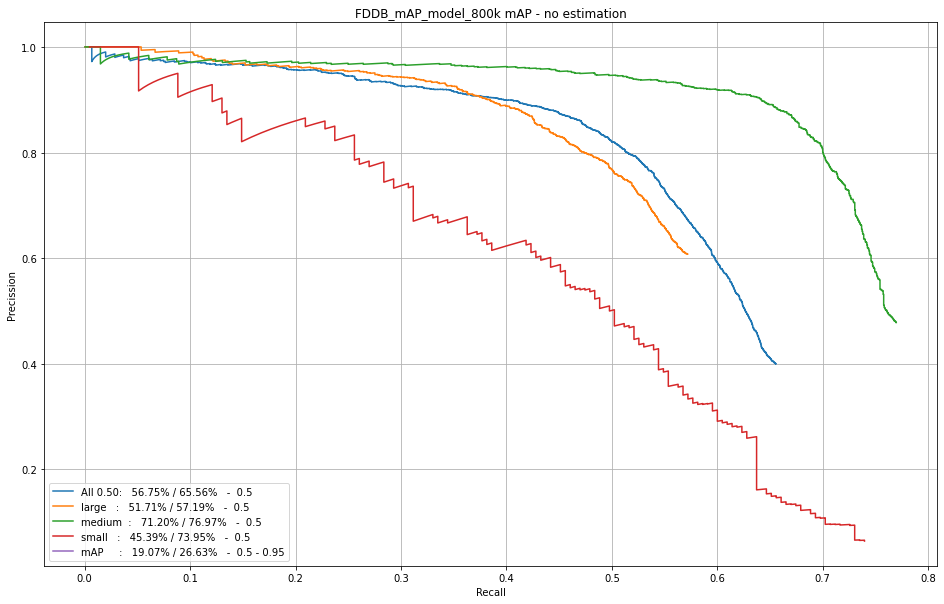

In [ ]:
modelshow = list(pred.keys())[0]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="FDDB_mAP_model_")

## Model: BN_800k


Model: BN_800k
All 0.50:   AP: 89.78%   Recall: 90.47%   IoU: 0.5
large   :   AP: 96.36%   Recall: 96.51%   IoU: 0.5
medium  :   AP: 82.23%   Recall: 83.35%   IoU: 0.5
small   :   AP: 59.64%   Recall: 73.95%   IoU: 0.5
mAP     :   AP: 40.34%   Recall: 46.36%   IoU: 0.5 - 0.95


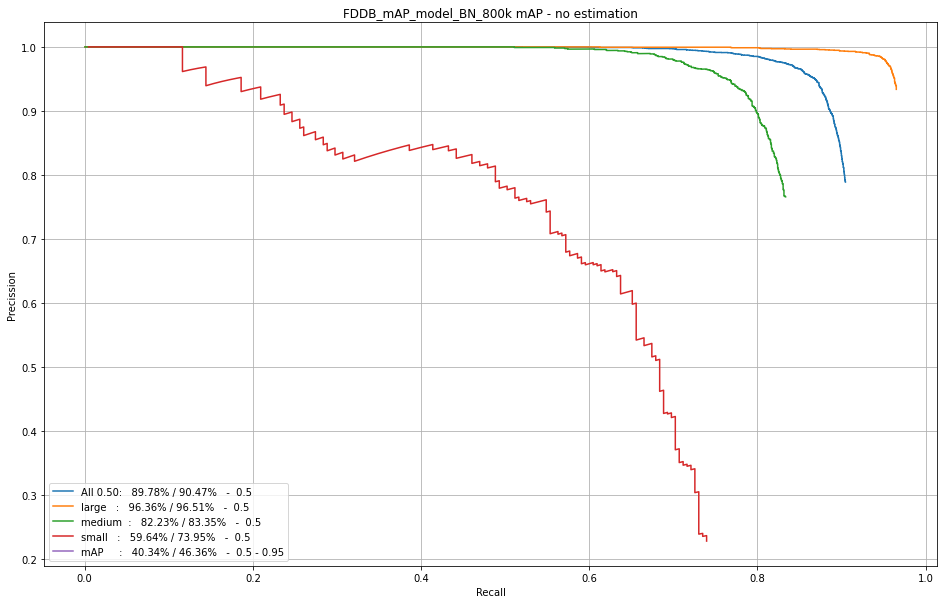

In [ ]:
modelshow = list(pred.keys())[1]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="FDDB_mAP_model_")

## Model: BN_Mish_V2_250+F_2_50k

Model: BN_Mish_V2_250+F_2_50k
All 0.50:   AP: 91.69%   Recall: 92.36%   IoU: 0.5
large   :   AP: 96.92%   Recall: 97.05%   IoU: 0.5
medium  :   AP: 85.37%   Recall: 86.54%   IoU: 0.5
small   :   AP: 64.55%   Recall: 82.33%   IoU: 0.5
mAP     :   AP: 38.29%   Recall: 43.89%   IoU: 0.5 - 0.95


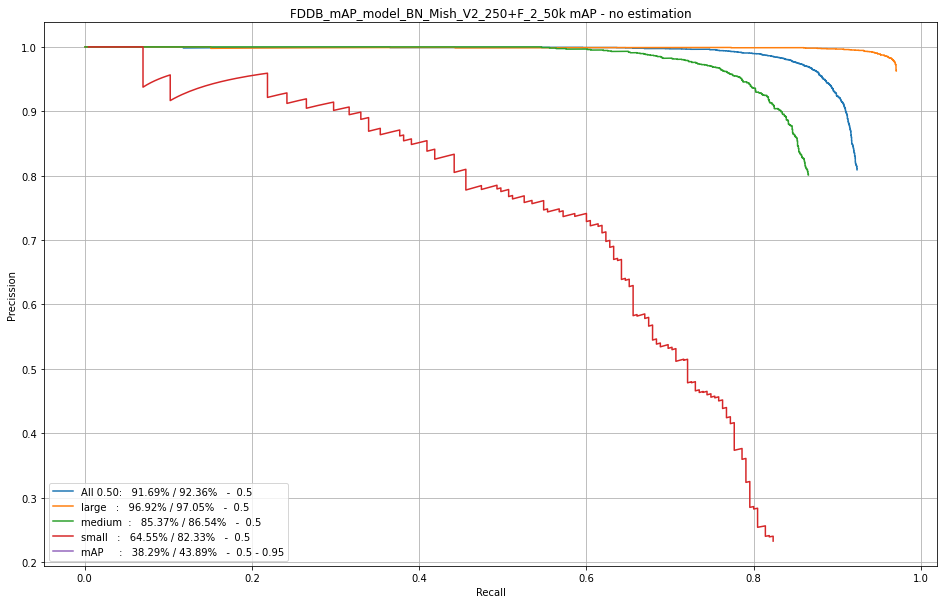

In [ ]:
modelshow = list(pred.keys())[2]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="FDDB_mAP_model_")

## Model: BN_Mish_V3_80+_30k

Model: BN_Mish_V3_80+_30k
All 0.50:   AP: 91.09%   Recall: 91.72%   IoU: 0.5
large   :   AP: 97.04%   Recall: 97.19%   IoU: 0.5
medium  :   AP: 84.32%   Recall: 85.19%   IoU: 0.5
small   :   AP: 60.59%   Recall: 77.67%   IoU: 0.5
mAP     :   AP: 40.21%   Recall: 46.16%   IoU: 0.5 - 0.95


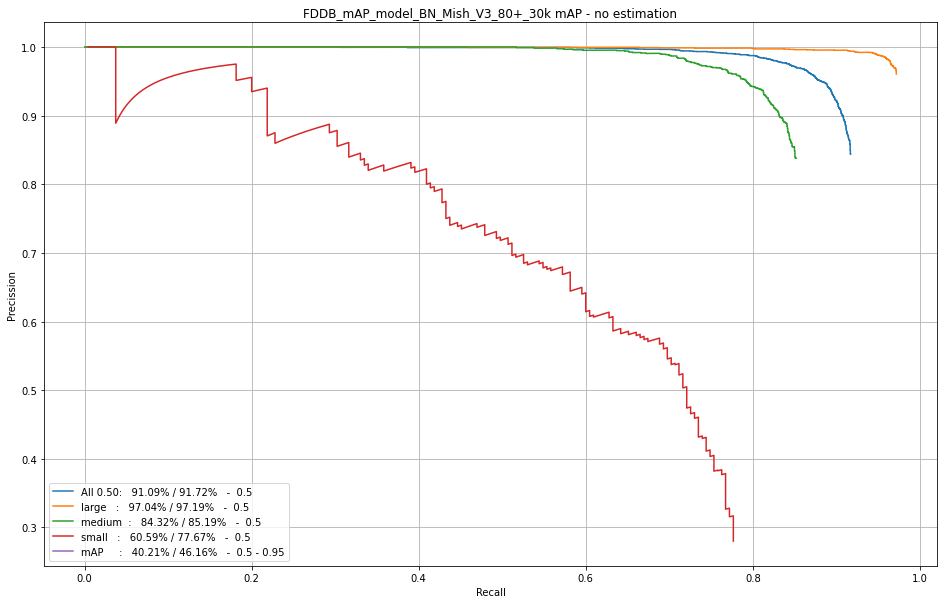

In [ ]:
modelshow = list(pred.keys())[3]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="FDDB_mAP_model_")

## Model: faster_rcnn_R_50_FPN_3x

Model: faster_rcnn_R_50_FPN_3x
All 0.50:   AP: 92.23%   Recall: 92.90%   IoU: 0.5
large   :   AP: 97.89%   Recall: 98.03%   IoU: 0.5
medium  :   AP: 85.68%   Recall: 86.89%   IoU: 0.5
small   :   AP: 62.84%   Recall: 78.60%   IoU: 0.5
mAP     :   AP: 40.08%   Recall: 46.20%   IoU: 0.5 - 0.95


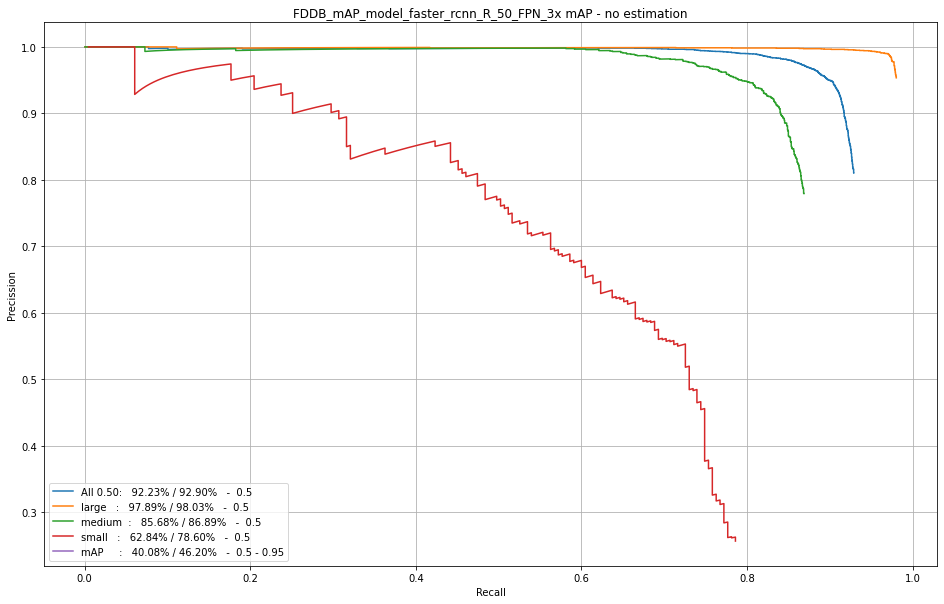

In [ ]:
modelshow = list(pred.keys())[4]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="FDDB_mAP_model_")

## Model: scratch_faster_rcnn_R_50_FPN_gn

Model: scratch_faster_rcnn_R_50_FPN_gn
All 0.50:   AP: 90.08%   Recall: 90.93%   IoU: 0.5
large   :   AP: 96.79%   Recall: 96.92%   IoU: 0.5
medium  :   AP: 82.33%   Recall: 83.90%   IoU: 0.5
small   :   AP: 57.22%   Recall: 74.42%   IoU: 0.5
mAP     :   AP: 38.44%   Recall: 45.51%   IoU: 0.5 - 0.95


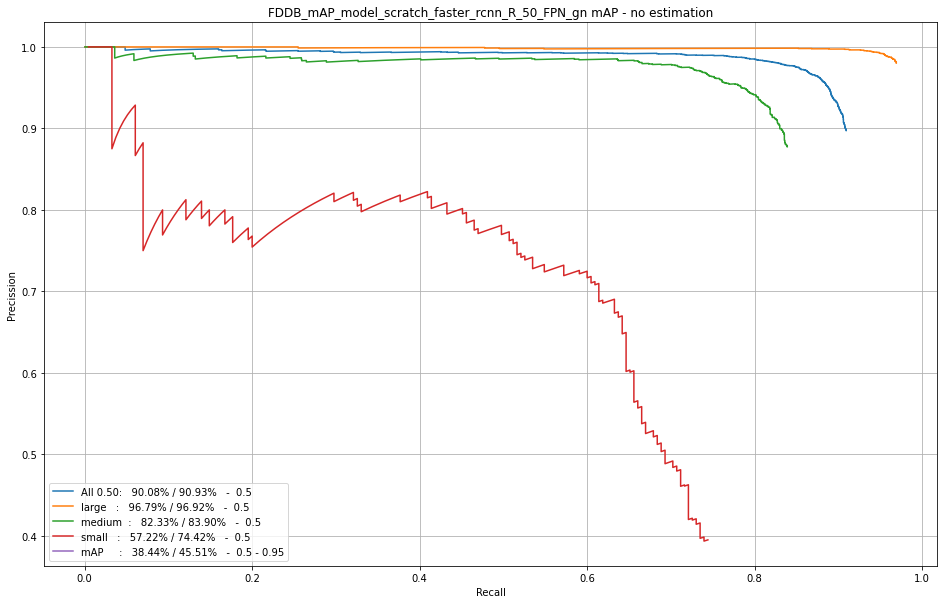

In [ ]:
modelshow = list(pred.keys())[5]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="FDDB_mAP_model_")

## Model: MTCNN

Model: MTCNN
All 0.50:   AP: 76.76%   Recall: 77.32%   IoU: 0.5
large   :   AP: 87.70%   Recall: 88.07%   IoU: 0.5
medium  :   AP: 65.30%   Recall: 66.20%   IoU: 0.5
small   :   AP: 29.55%   Recall: 33.49%   IoU: 0.5
mAP     :   AP: 22.67%   Recall: 28.57%   IoU: 0.5 - 0.95


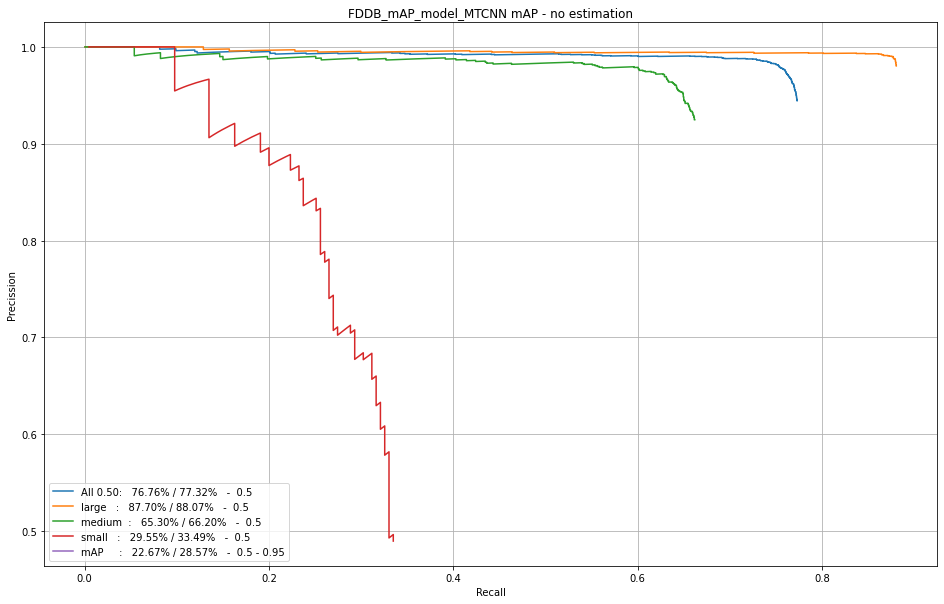

In [ ]:
modelshow = list(pred.keys())[6]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="FDDB_mAP_model_")

In [ ]:
!mv unified_mAP*.png ./drive/'My Drive'/FDDB_OUTPUT_DIR/

Zapis wyników na Google drive

In [ ]:
output_file_name = "unified_mAP_all_models"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
dict_to_file(all_models_mAP, output_file)

In [ ]:
all_models_mAP.keys()

dict_keys(['800k', 'BN_800k', 'BN_Mish_V2_250+F_2_50k', 'BN_Mish_V3_80+_30k', 'faster_rcnn_R_50_FPN_3x', 'scratch_faster_rcnn_R_50_FPN_gn', 'MTCNN'])

In [ ]:
modeldict = {}
DD_mAP = {}

for item in all_models_mAP.keys():
  for i in all_models_mAP[item][0].keys():
    modeldict[i] =  {
        "AP" : all_models_mAP[item][0][i][0],
        "Recall" : all_models_mAP[item][0][i][1],
        "IoU" : all_models_mAP[item][0][i][2],
    }
  DD_mAP[item] = modeldict 

In [ ]:
output_file_name = "DD_mAP_all_models"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
dict_to_file(DD_mAP, output_file)

In [ ]:
from collections import OrderedDict

DD_mAP2 = OrderedDict()

for item in all_models_mAP.keys():
  DD_mAP2[item] = ({i:all_models_mAP[item][0][i][0] for i in ['mAP', 'All 0.50','large','medium','small']})

df_unified_mAP = pd.DataFrame.from_dict(DD_mAP2, orient='index').sort_values(by=['All 0.50'], ascending=False)
df_unified_mAP

,mAP,All 0.50,large,medium,small
faster_rcnn_R_50_FPN_3x,0.400832,0.922293,0.978863,0.856809,0.628422
BN_Mish_V2_250+F_2_50k,0.382871,0.916938,0.969164,0.853672,0.645481
BN_Mish_V3_80+_30k,0.402092,0.910858,0.970415,0.843167,0.605858
scratch_faster_rcnn_R_50_FPN_gn,0.384401,0.900806,0.967853,0.823343,0.572182
BN_800k,0.403373,0.897774,0.963604,0.822335,0.596383
MTCNN,0.226706,0.767601,0.876966,0.653019,0.295505
800k,0.190720,0.567498,0.517141,0.712006,0.453871


In [ ]:
df_unified_mAP_results = df_unified_mAP.to_json(orient="table")

output_file_name = "unified_mAP_dataframe.json"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)

with open(output_file, 'w') as f:
  json.dump(df_unified_mAP_results, f, indent=4)  

In [ ]:
with open(output_file) as data_file:
    data_loaded = json.load(data_file)
pd.read_json(data_loaded, orient="table" )

,mAP,All 0.50,large,medium,small
faster_rcnn_R_50_FPN_3x,0.400832,0.922293,0.978863,0.856809,0.628422
BN_Mish_V2_250+F_2_50k,0.382871,0.916938,0.969164,0.853672,0.645481
BN_Mish_V3_80+_30k,0.402092,0.910858,0.970415,0.843167,0.605858
scratch_faster_rcnn_R_50_FPN_gn,0.384401,0.900806,0.967853,0.823343,0.572182
BN_800k,0.403373,0.897774,0.963604,0.822335,0.596383
MTCNN,0.226706,0.767601,0.876966,0.653019,0.295505
800k,0.190720,0.567498,0.517141,0.712006,0.453871


# Ewaluacja na FDDB z wykorzystaniem COCOEvaluator i inference_on_dataset


In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [ ]:
AP_VAL = {}

for model in models_mnv2:
  print(model)
  destination = os.path.join(OUTPUT_DIR_PATH, model)
  if not os.path.exists(destination):
    os.makedirs(destination)
  predictor, cfg = set_predictor(model, cfg_DATASETS_TEST="faces_val")
  print(destination)

  evaluator = COCOEvaluator(cfg.DATASETS.TEST[0], cfg, True, output_dir=destination)
  val_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
  inference_on_dataset(predictor.model, val_loader, evaluator)
  AP_VAL[model] = evaluator.evaluate()

800k
./drive/My Drive/FDDB_OUTPUT_DIR/800k
[08/20 22:06:12 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    face    | 5171         |
|            |              |
[08/20 22:06:12 d2.data.common]: Serializing 2845 elements to byte tensors and concatenating them all ...
[08/20 22:06:12 d2.data.common]: Serialized dataset takes 0.86 MiB
[08/20 22:06:12 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/20 22:06:12 d2.evaluation.evaluator]: Start inference on 2845 images
[08/20 22:06:13 d2.evaluation.evaluator]: Inference done 11/2845. 0.0447 s / img. ETA=0:02:09
[08/20 22:06:18 d2.evaluation.evaluator]: Inference done 120/2845. 0.0446 s / img. ETA=0:02:05
[08/20 22:06:23 d2.evaluation.evaluator]: Inference done 229/2845. 0.0447 s / img. ETA=0:02:00
[08/20 22:06:28 d2.evaluation.evaluator]: Inference done 339/28

In [ ]:
for model in faster_rcnn_model:
  print(model)
  destination = os.path.join(OUTPUT_DIR_PATH, model)
  if not os.path.exists(destination):
    os.makedirs(destination)
  predictor, cfg = faster_predictor(model, cfg_DATASETS_TEST="faces_val")
  print(destination)

  evaluator = COCOEvaluator(cfg.DATASETS.TEST[0], cfg, True, output_dir=destination)
  val_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
  inference_on_dataset(predictor.model, val_loader, evaluator)
  AP_VAL[model] = evaluator.evaluate()

faster_rcnn_R_50_FPN_3x
./drive/My Drive/FDDB_OUTPUT_DIR/faster_rcnn_R_50_FPN_3x
[08/20 22:16:11 d2.data.common]: Serializing 2845 elements to byte tensors and concatenating them all ...
[08/20 22:16:11 d2.data.common]: Serialized dataset takes 0.86 MiB
[08/20 22:16:11 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/20 22:16:11 d2.evaluation.evaluator]: Start inference on 2845 images
[08/20 22:16:12 d2.evaluation.evaluator]: Inference done 11/2845. 0.0647 s / img. ETA=0:03:06
[08/20 22:16:17 d2.evaluation.evaluator]: Inference done 88/2845. 0.0639 s / img. ETA=0:03:00
[08/20 22:16:22 d2.evaluation.evaluator]: Inference done 164/2845. 0.0643 s / img. ETA=0:02:56
[08/20 22:16:27 d2.evaluation.evaluator]: Inference done 240/2845. 0.0645 s / img. ETA=0:02:51
[08/20 22:16:32 d2.evaluation.evaluator]: Inference done 316/2845. 0.0646 s / img. ETA=0:02:47
[08/20 22:16:37 d2.evaluation.evaluato

In [ ]:
output_file_name = "AP_VAL_COCOEvaluator"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
dict_to_file(AP_VAL, output_file)

Porównanie wyników

In [ ]:
AP_FDDB = {}
for item in AP_VAL.keys():
  AP_FDDB[item] = AP_VAL[item]['bbox']

df_AP_FDDB = pd.DataFrame.from_dict(AP_FDDB, orient='index').sort_values(by=['AP50'], ascending=False)

In [ ]:
 df_AP_FDDB

,AP,AP50,AP75,APs,APm,APl
faster_rcnn_R_50_FPN_3x,39.450135,91.435634,14.762144,18.345349,34.032336,45.124748
BN_Mish_V2_250+F_2_50k,37.604153,90.541335,10.509456,19.019576,32.083840,42.632895
BN_Mish_V3_80+_30k,39.490323,90.495200,15.789375,18.186023,32.996425,46.237979
BN_800k,39.692626,89.397019,18.394331,18.949486,32.746256,46.565123
scratch_faster_rcnn_R_50_FPN_gn,37.811685,89.204056,14.963983,16.882938,31.184698,44.683578
800k,19.019075,57.739784,3.562887,13.693709,25.407776,17.908660


Zapis wyników na Google drive

In [ ]:
df_AP_FDDB_results = df_AP_FDDB.to_json(orient="table")

output_file_name = "df_AP_FDDB.json"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)

with open(output_file, 'w') as f:
  json.dump(df_AP_FDDB_results, f, indent=4)  

In [ ]:
with open(output_file) as data_file:
    data_loaded = json.load(data_file)
pd.read_json(data_loaded, orient="table" )

,AP,AP50,AP75,APs,APm,APl
faster_rcnn_R_50_FPN_3x,39.450135,91.435634,14.762144,18.345349,34.032336,45.124748
BN_Mish_V2_250+F_2_50k,37.604153,90.541335,10.509456,19.019576,32.083840,42.632895
BN_Mish_V3_80+_30k,39.490323,90.495200,15.789375,18.186023,32.996425,46.237979
BN_800k,39.692626,89.397019,18.394331,18.949486,32.746256,46.565123
scratch_faster_rcnn_R_50_FPN_gn,37.811685,89.204056,14.963983,16.882938,31.184698,44.683578
800k,19.019075,57.739784,3.562887,13.693709,25.407776,17.908660


Wybór modelu do testu na zbiorze testowym

<br>

[6.2 Wyniki na zbiorze WIDER FACE](06_02_WIDERFACE_TEST.ipynb)

<br>


---

[Spis treści](https://github.com/DarekGit/FACES_DNN/blob/master/notebooks/Praca_Dyplomowa.ipynb) | [1. Wstęp](01_00_Wstep.ipynb) | [2. Metryki oceny detekcji](02_00_Miary.ipynb) | [3 .Bazy danych](03_00_Datasety.ipynb) | [4. Przegląd metod detekcji](04_00_Modele.ipynb) | [5. Detekcja twarzy z wykorzystaniem wybranych architektur GSN](05_00_Modyfikacje.ipynb) | [6. Porównanie modeli](06_00_Porownanie.ipynb) | [7. Eksport modelu](07_00_Eksport_modelu.ipynb) | [8. Podsumowanie i wnioski](08_00_Podsumowanie.ipynb) | [Bibliografia](Bibliografia.ipynb)


---